# Setup

In [1]:
''' magic 4u '''

%load_ext autoreload
%autoreload 2

In [2]:
''' get stuff you need '''
from os.path import exists, join
import numpy as np
import pandas as pd
from copy import deepcopy
import re
import glob
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#from spikeinterface.extractors.neoextractors import SpikeGLXRecordingExtractor
from spectral_connectivity import Multitaper, Connectivity
from scipy.signal import filtfilt, hilbert, remez, find_peaks
from scipy import stats

from pipeline import get_data as get
from pipeline import process_spikes as ps
from pipeline.lfp import LFP
from pipeline.utilities import get_starts
import os
from phylib.io.model import load_model

import fnmatch
import pipeline.lfp as lf
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

#define this useful function for later
def find(x):
    return x.nonzero()[0]

In [3]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])
animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [4]:
''' Load in Animal Metadata '''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/SessionMetadata.csv') #adjust path name
print(sessionmeta.head())

                                    File Animal_ID  Session  Sync  \
0  A3_210122_randomforagecuerich_record1        A3        1     1   
1  A3_211023_randomforagecuerich_record2        A3        2     1   
2  A3_211024_randomforagecuerich_record3        A3        3     1   
3  A3_210125_randomforagecuerich_record4        A3        4     1   
4  A3_210126_randomforagecuerich_record5        A3        5     1   

   Final Depth (D)  Final Depth (V)  Angle  Notes  
0             3510             3450   10.61   NaN  
1             3637             3575   10.59   NaN  
2             4120             4050   10.58   NaN  
3             3917             3850   10.61   NaN  
4             3765             3700   10.66   NaN  


# Edit these paths

In [ ]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
lfp_folder = 'C:/Users/Python/Desktop/Dryad/processed_lfp_files/' # adjust to match location of this Dryad repo folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure4/' 

# Plot example spectrograms (Figure 4a)

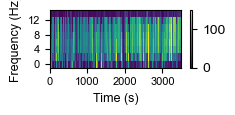

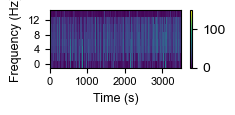

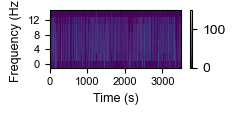

In [5]:
'''Load in data & plot example theta spectrograms (Figure 4a top row)'''


mice = ['Y4', 'MA1F', 'A13']
sessions = [['1114_record1'],['102322_record1'],['051022_record6']]
counts = [1,1,6]

window = 0.5
low = 6
high = 12
low_display = 1
high_display = 15

count = 0 
for m, session in zip(mice, sessions):
    seshcount = counts[count]
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])

        #load, process, & save LFP for only for max theta channel
        lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
        lfp = LFP(name = lfp_name)

        #plot pretty example spectrograms
        rate = lfp.rate
         
        # calculate spectrogram
        multi = Multitaper(lfp.lfp, sampling_frequency=rate,
                       time_window_duration=window, time_window_step=window)
        c = Connectivity.from_multitaper(multi)  # shape: windows x freqs x channels
    
        # find the target bands (inclusive)
        low_idx, high_idx = lf.get_inclusive_indices(low, high, c.frequencies)
        low_disp_idx, high_disp_idx = lf.get_inclusive_indices(
            low_display, high_display, c.frequencies)
    
        # extract power and timestamps
        power = np.mean(c.power()[:, low_idx:high_idx, 0].squeeze(), 1)
        n_samples = int(window * rate)
        timestamps = np.arange(0, lfp.lfp.shape[0])
        index = timestamps[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
        power = pd.DataFrame(power, index=index)
        timestamps = power.index/rate

        #plot spectrograms for top row of Figure 4A
        f, ax0  = plt.subplots(figsize=(2.125, 0.75))
        # spectrogram
        im = ax0.pcolormesh(timestamps[timestamps <= 3500], c.frequencies[low_disp_idx:high_disp_idx],
                      c.power()[:, low_disp_idx:high_disp_idx, 0][timestamps <= 3500].squeeze().T, vmin = 0 , vmax = 150, cmap='viridis')
        f.colorbar(im, ax = ax0)
        ax0.set_xlabel('Time (s)', fontsize = 9)
        ax0.set_xticks([0,1000,2000,3000])
        ax0.set_yticks([0,4,8,12])
        ax0.tick_params(labelsize = 8)
        ax0.set_ylabel('Frequency (Hz)', fontsize = 9) 
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_theta_4A.png', dpi = 400, bbox_inches = 'tight')
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_theta_4A.svg', dpi = 400, bbox_inches = 'tight')
        plt.show()

        count += 1 

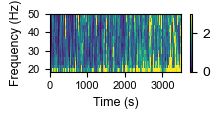

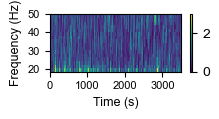

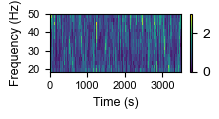

In [6]:
'''Load in data & plot example slow gamma spectrograms (Figure 4a middle row)'''
window = 0.5
low = 20
high = 50
low_display = 20
high_display = 50

count = 0 
for m, session in zip(mice, sessions):
    seshcount = counts[count]
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])

        #load, process, & save LFP for only for max theta channel
        lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
        lfp = LFP(name = lfp_name)

        #plot pretty example spectrograms
        rate = lfp.rate

        # calculate spectrogram
        multi = Multitaper(lfp.lfp, sampling_frequency=rate,
                       time_window_duration=window, time_window_step=window)
        c = Connectivity.from_multitaper(multi)  # shape: windows x freqs x channels
    
        # find the target bands (inclusive)
        low_idx, high_idx = lf.get_inclusive_indices(low, high, c.frequencies)
        low_disp_idx, high_disp_idx = lf.get_inclusive_indices(
            low_display, high_display, c.frequencies)
    
        # extract power and timestamps
        power = np.mean(c.power()[:, low_idx:high_idx, 0].squeeze(), 1)
        n_samples = int(window * rate)
        timestamps = np.arange(0, lfp.lfp.shape[0])
        index = timestamps[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
        power = pd.DataFrame(power, index=index)
        timestamps = power.index/rate

        #plot spectrograms for top row of Figure 4A
        f, ax0  = plt.subplots(figsize=(2.125, 0.75))
        # spectrogram
        im = ax0.pcolormesh(timestamps[timestamps <= 3500], c.frequencies[low_disp_idx:high_disp_idx],
                      c.power()[:, low_disp_idx:high_disp_idx, 0][timestamps <= 3500].squeeze().T, vmin = 0 , vmax = 3, cmap='viridis')
        f.colorbar(im, ax = ax0)
        ax0.set_xlabel('Time (s)', fontsize = 9)
        ax0.set_xticks([0,1000,2000,3000])
        ax0.set_yticks([20,30,40,50])
        ax0.tick_params(labelsize = 8)
        ax0.set_ylabel('Frequency (Hz)', fontsize = 9) 
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_SG_4A.png', dpi = 400, bbox_inches = 'tight')
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_SG_4A.svg', dpi = 400, bbox_inches = 'tight')
        plt.show()

        count += 1 

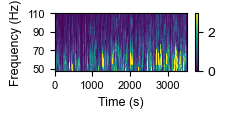

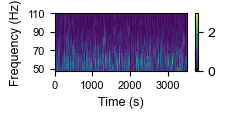

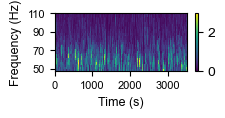

In [7]:
'''Load in data & plot example fast gamma spectrograms (Figure 4a bottom row)'''
window = 0.5
low = 50
high = 110
low_display = 50
high_display = 110

count = 0 
for m, session in zip(mice, sessions):
    seshcount = counts[count]
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])

        #load, process, & save LFP for only for max theta channel
        lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
        lfp = LFP(name = lfp_name)

        #plot pretty example spectrograms
        rate = lfp.rate

        # calculate spectrogram
        multi = Multitaper(lfp.lfp, sampling_frequency=rate,
                       time_window_duration=window, time_window_step=window)
        c = Connectivity.from_multitaper(multi)  # shape: windows x freqs x channels
    
        # find the target bands (inclusive)
        low_idx, high_idx = lf.get_inclusive_indices(low, high, c.frequencies)
        low_disp_idx, high_disp_idx = lf.get_inclusive_indices(
            low_display, high_display, c.frequencies)
    
        # extract power and timestamps
        power = np.mean(c.power()[:, low_idx:high_idx, 0].squeeze(), 1)
        n_samples = int(window * rate)
        timestamps = np.arange(0, lfp.lfp.shape[0])
        index = timestamps[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
        power = pd.DataFrame(power, index=index)
        timestamps = power.index/rate

        #plot spectrograms for top row of Figure 4A
        f, ax0  = plt.subplots(figsize=(2.125, 0.75))
        # spectrogram
        im = ax0.pcolormesh(timestamps[timestamps <= 3500], c.frequencies[low_disp_idx:high_disp_idx],
                      c.power()[:, low_disp_idx:high_disp_idx, 0][timestamps <= 3500].squeeze().T, vmin = 0 , vmax = 3, cmap='viridis')
        f.colorbar(im, ax = ax0)
        ax0.set_xlabel('Time (s)', fontsize = 9)
        ax0.set_xticks([0,1000,2000,3000])
        ax0.set_yticks([50,70,90,110])
        ax0.tick_params(labelsize = 8)
        ax0.set_ylabel('Frequency (Hz)', fontsize = 9) 
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_FG_4A.png', dpi = 400, bbox_inches = 'tight')
        plt.savefig(save_folder + '_' + str(m) + '_' + str(s) + '_FG_4A.svg', dpi = 400, bbox_inches = 'tight')
        plt.show()

        count += 1 

# Plot power spectral densities (Figure 4b)

In [12]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [13]:
''' Set Up Data Dictionary ''' 

mice = all_mice
sessions = all_sessions

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [49]:
''' Gather PSD for each Session from Raw LFP Data ''' 

mice = all_mice
sessions = all_sessions

#get session count by age group
n_agedsesh = 0
n_youngsesh = 0
n_MAsesh = 0 

for m, session in zip(mice, sessions):
     for s in session:
        if m in all_aged_mice:
            n_agedsesh += 1
        elif m in all_MA_mice:
            n_MAsesh += 1
        else:
            n_youngsesh +=1

#set up empty arrays for PSDs
freqs = []
apsds = np.zeros((n_agedsesh, 129))
mapsds = np.zeros((n_MAsesh, 129))
ypsds = np.zeros((n_youngsesh, 129))

n_a = -1
n_y = -1
n_MA = -1
for m, session in zip(mice, sessions):
    seshcount = 1
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])   
        seshcount += 1

        #load, process, & save LFP for only for max theta channel
        d = data[m][s]

        if m in all_aged_mice:
            n_a += 1
        elif m in all_MA_mice:
            n_MA += 1
        else:
            n_y +=1

        if m in ['Y19']: 
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced2.csv'
        else:
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
        lfp = LFP(name = lfp_name)

        if n_a == 0:
            freq, psd = signal.welch(np.squeeze(lfp.lfp), lfp.rate)
            freqs = np.append(freqs,freq)
        else:
            _, psd = signal.welch(np.squeeze(lfp.lfp), lfp.rate)
        
        if m in all_aged_mice:
            apsds[n_a,:] = psd
        elif m in all_MA_mice:
            mapsds[n_MA,:] = psd
        else:
            ypsds[n_y,:] = psd 

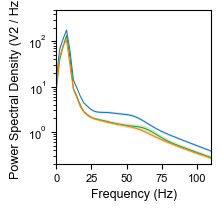

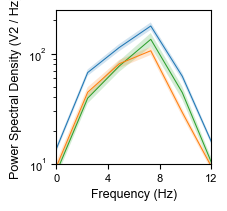

In [52]:
''' Plot Average PSD by Age Group (Figure 4b) '''

plot_dest_file_top = save_folder + '4Btop' + '.png'
plot_dest_file_top_svg = save_folder + '4Btop' + '.svg'

plot_dest_file_bottom = save_folder + '4Bbottom' + '.png'
plot_dest_file_bottom_svg = save_folder + '4Bbottom' + '.svg'

# plot averages & SEM
avgapsd = np.mean(apsds, axis = 0)
avgmapsd = np.mean(mapsds, axis = 0)
avgypsd = np.mean(ypsds, axis = 0)

SEMapsd = stats.sem(apsds, axis = 0)
SEMmapsd = stats.sem(mapsds, axis = 0)
SEMypsd = stats.sem(ypsds, axis = 0)

#plot PSDs together color coded for manuscript
fig, ax = plt.subplots(figsize = (2,2))
plt.semilogy(freqs, avgypsd, color = 'C0', label = 'Young', linewidth = 0.75) 
plt.fill_between(freqs, (avgypsd - SEMypsd), (avgypsd + SEMypsd), facecolor = 'C0', alpha = 0.2)
plt.semilogy(freqs, avgmapsd, color = 'C2', label = 'MA', linewidth = 0.75) 
plt.fill_between(freqs, avgmapsd - SEMmapsd, avgmapsd + SEMmapsd, facecolor = 'C2', alpha = 0.2)
plt.semilogy(freqs, avgapsd, color = 'C1', label = 'Aged', linewidth = 0.75) 
plt.fill_between(freqs, avgapsd - SEMapsd, avgapsd + SEMapsd, facecolor = 'C1', alpha = 0.2)
plt.xlim([0, 110])
plt.ylim([0.2, 500])
ax.set_xticks([0, 25, 50, 75, 100])
ax.tick_params(labelsize = 8)
plt.xlabel('Frequency (Hz)', fontsize = 9)
plt.ylabel('Power Spectral Density (V2 / Hz)', fontsize  = 9)
#plt.title('Mean Power Spectral Density by Age Group')
#plt.legend(loc=1, prop={'size': 18})
plt.savefig(plot_dest_file_top, dpi = 400, bbox_inches = 'tight')
plt.savefig(plot_dest_file_top_svg, dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2,2))
plt.semilogy(freqs, avgypsd, color = 'C0', label = 'Young', linewidth = 0.75) 
plt.fill_between(freqs, (avgypsd - SEMypsd), (avgypsd + SEMypsd), facecolor = 'C0', alpha = 0.2)
plt.semilogy(freqs, avgmapsd, color = 'C2', label = 'MA', linewidth = 0.75) 
plt.fill_between(freqs, avgmapsd - SEMmapsd, avgmapsd + SEMmapsd, facecolor = 'C2', alpha = 0.2)
plt.semilogy(freqs, avgapsd, color = 'C1', label = 'Aged', linewidth = 0.75) 
plt.fill_between(freqs, avgapsd - SEMapsd, avgapsd + SEMapsd, facecolor = 'C1', alpha = 0.2)
plt.xlim([0, 12])
ax.set_xticks([0, 4, 8, 12])
plt.ylim([10, 250])
ax.tick_params(labelsize = 8)
plt.xlabel('Frequency (Hz)', fontsize = 9)
plt.ylabel('Power Spectral Density (V2 / Hz)', fontsize  = 9)
#plt.title('Mean Power Spectral Density by Age Group')
plt.savefig(plot_dest_file_bottom, dpi = 400, bbox_inches = 'tight')
plt.savefig(plot_dest_file_bottom_svg, dpi = 400, bbox_inches = 'tight')
plt.show()

# Plot power during running (Figure 4c)

In [ ]:
'''Load in synced LFP data & save power along entire session length as .npy each frequency band '''

mice = all_mice
sessions = all_sessions

for m, session in zip(mice, sessions):
    seshcount = 1
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])  
        seshcount += 1

        #load, process, & save LFP for only for max theta channel
        d = data[m][s]

        if m in ['Y19']: 
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced2.csv'
        else:
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
            
        lfp = LFP(name = lfp_name)

        #calculate power in each frequency band over entire session
        theta_power, _ = lf.multitaper_filtered_power(lfp.lfp, low=lf.THETA[0], high=lf.THETA[1], window=0.5)
        SG_power, _  = lf.multitaper_filtered_power(lfp.lfp, low=lf.SLOW_GAMMA[0], high=lf.SLOW_GAMMA[1], window=0.5)
        FG_power, _ = lf.multitaper_filtered_power(lfp.lfp, low=lf.FAST_GAMMA[0], high=lf.FAST_GAMMA[1], window=0.5)

        #save each array as .npy
        theta_power_file = 'thetapower_' + m + '_' + s + '.npy'
        SG_power_file = 'SG_' + m + '_' + s + '.npy'
        FG_power_file = 'FG_' + m + '_' + s + '.npy'
        np.save(save_folder + theta_power_file, theta_power)
        np.save(save_folder + SG_power_file, SG_power)
        np.save(save_folder + FG_power_file, FG_power)

In [14]:
''' Compute Mean, Speed-Matched Theta Power while Running'''

mice = all_mice
sessions = all_sessions

from tqdm import tqdm
from sklearn.utils import resample

window = 0.5
min_speed = 20 
max_speed = 40 

mtp = []
mSGp = []
mFGp = []

stp = []
sSGp = []
sFGp = []

smeanspeed = []
speakspeed = []
mmeanspeed = []
mpeakspeed = []

for m, session in zip(mice, sessions):
    seshcount = 1
    m_speed = []
    m_theta = []
    m_FG = []
    m_SG = []
    
    for s in session:

        #define LFP name stem
        rec_file_stem = str(np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'File'])[0])
        seshcount += 1

        #load, process, & save LFP for only for max theta channel
        d = data[m][s]

        if m in ['Y19']: 
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced2.csv'
        else:
            lfp_name = lfp_folder + '/' + rec_file_stem + '_maxthetaLFPsynced.csv'
        lfp = LFP(name = lfp_name)

        #laod in each saved power array as .npy
        theta_power_file = 'thetapower_' + m + '_' + s + '.npy'
        SG_power_file = 'SG_' + m + '_' + s + '.npy'
        FG_power_file = 'FG_' + m + '_' + s + '.npy'
        theta_power = np.load(save_folder + theta_power_file)
        SG_power = np.load(save_folder + SG_power_file)
        FG_power = np.load(save_folder + FG_power_file)

        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        #load npy files
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        #load raw speed (including periods with <2cms)
        speed = raw.item().get('speed') #sampled at 50Hz
        post = raw.item().get('post') #sampled at 50Hz, every 0.02s vs. LFP power at 2Hz, every 0.5 seconds

        #upsample each power array to 50Hz
        n_samples = int(window * lfp.rate)
        timestamps = np.arange(0,lfp.timestamps.shape[0])
        index = timestamps[np.arange(1, FG_power.shape[0] * n_samples + 1, n_samples)]
        times = index/lfp.rate
        index = pd.to_datetime(np.array(times), unit = 's')
         
        df = pd.Series(FG_power, index = index)
        upsampFG = df.resample('20ms').mean().interpolate(method ='spline', order = 2)
        upFGpower = upsampFG.to_numpy()
        uptimes = np.arange(0, len(upFGpower)*0.02, 0.02)

        df = pd.Series(SG_power, index = index)
        upsampSG = df.resample('20ms').mean().interpolate(method ='spline', order = 2)
        upSGpower = upsampSG.to_numpy()

        df = pd.Series(theta_power, index = index)
        upsamptheta = df.resample('20ms').mean().interpolate(method ='spline', order = 2)
        upthetapower = upsamptheta.to_numpy()

        if len(uptimes) > len(upFGpower):
            uptimes = uptimes[:-1]

        #remove extra timebins at the end of the recording
        n_extraframes = len(post) - len(uptimes)
        post = post[:-n_extraframes]
        speed = speed[:-n_extraframes]

        if len(uptimes) != len(speed):
            if len(upFGpower) > len(speed):
                nextratimestamps = len(uptimes) - len(speed)
                print(nextratimestamps)
                print(uptimes[0:5],post[0:5], uptimes[-5:-1],post[-5:-1])
            else:
                nextratimestamps = len(speed) - len(uptimes)
                print(nextratimestamps)
                print(uptimes[0:5],post[0:5], uptimes[-5:-1],post[-5:-1])

        #filter out periods of running >40cm/s and <20cm/s
        speed_idx = find((speed < min_speed) | (speed > max_speed))
        keep_idx = np.setdiff1d(np.arange(speed.shape[0]), speed_idx)
        upFGpower = upFGpower[keep_idx]
        upSGpower = upSGpower[keep_idx]
        upthetapower = upthetapower[keep_idx]
        speed = speed[keep_idx]

        #save out stuff for mouse-level analysis
        m_speed = np.append(m_speed, speed)
        m_theta = np.append(m_theta, upthetapower)
        m_SG = np.append(m_SG, upSGpower)
        m_FG = np.append(m_FG, upFGpower)

        #compute session power averages
        stp = np.append(stp, np.mean(upthetapower))
        sSGp = np.append(sSGp, np.mean(upSGpower))
        sFGp = np.append(sFGp, np.mean(upFGpower))
         
        #compute speed for session
        smeanspeed = np.append(smeanspeed, np.mean(speed))
        speakspeed = np.append(speakspeed, np.max(speed))

    #compute speed for animal
    mmeanspeed = np.append(mmeanspeed, np.mean(m_speed))
    mpeakspeed = np.append(mpeakspeed, np.max(m_speed))

    #compute power averages for animal
    mtp = np.append(mtp, np.mean(m_theta))
    mSGp = np.append(mSGp, np.mean(m_SG))
    mFGp = np.append(mFGp, np.mean(m_FG))
    print('finished power analysis for ' + m )  

finished power analysis for A3
finished power analysis for A4
finished power analysis for A5
finished power analysis for A6
finished power analysis for A7
finished power analysis for Y2
finished power analysis for Y3
finished power analysis for Y4
finished power analysis for A12
finished power analysis for A13
finished power analysis for Y11
finished power analysis for Y16
finished power analysis for Y17
finished power analysis for Y18
finished power analysis for Y19
finished power analysis for Y9
finished power analysis for A14
finished power analysis for A15
finished power analysis for A16
finished power analysis for A17
finished power analysis for A18
finished power analysis for MA1F
finished power analysis for MA2F
finished power analysis for MA3M
finished power analysis for MA4M
finished power analysis for MA5M
finished power analysis for MA6M


C:\Users\Python\anaconda3\envs\LFPworld\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


finished power analysis for MA7M
finished power analysis for MA8F
finished power analysis for MA9F
finished power analysis for MA10F
finished power analysis for Y20
finished power analysis for Y21
finished power analysis for Y22
finished power analysis for Y23
finished power analysis for Y24
finished power analysis for A19
finished power analysis for A20
finished power analysis for A22
finished power analysis for A23
finished power analysis for A24
finished power analysis for Y25
finished power analysis for Y26


C:\Users\Python\anaconda3\envs\LFPworld\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


finished power analysis for Y27
finished power analysis for Y28


In [15]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [16]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

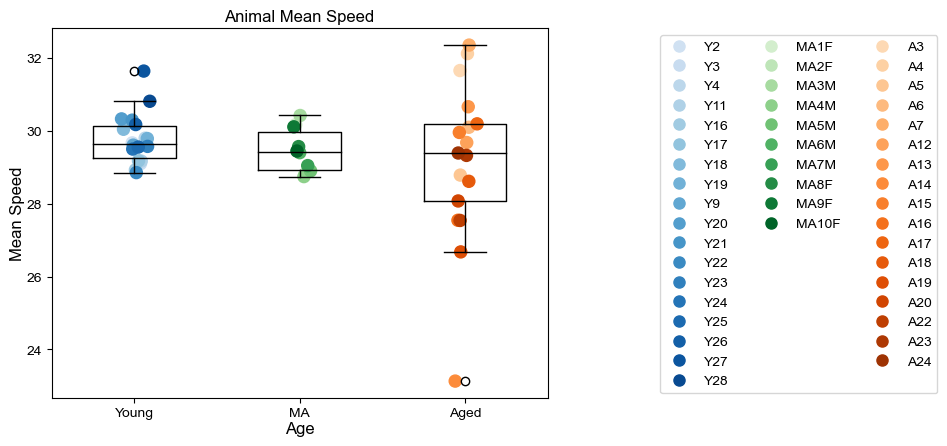

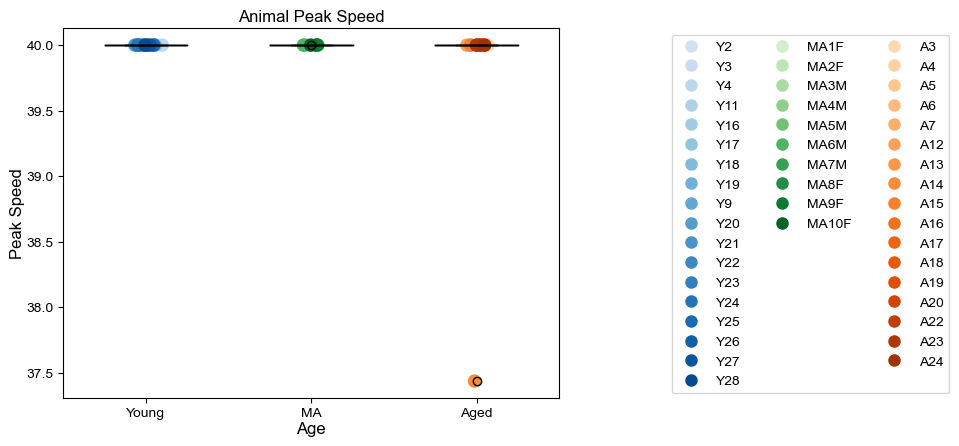

In [17]:
''' Compare Speed Distribution Features across Age Groups to Ensure Differences Collapse [Animal Level] '''
from itertools import repeat

fig, ax = plt.subplots()
meanspeed = [mmeanspeed[y_ind], mmeanspeed[ma_ind], mmeanspeed[age_ind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(meanspeed, widths = w, labels = labels, medianprops = dict(color = 'black'))

handles = []
for i in range(len(meanspeed)):
    y = meanspeed[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0][:len(y)], edgecolors = col_animal[i][0][:len(y)], s = 75)
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)

        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
            
ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('Animal Mean Speed', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=12, labelpad=1)
ax.set_ylabel('Mean Speed', fontsize=12, labelpad=1)
plt.show()

fig, ax = plt.subplots()
peakspeed = [mpeakspeed[y_ind], mpeakspeed[ma_ind], mpeakspeed[age_ind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(peakspeed, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(peakspeed)):
    y = peakspeed[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0][:len(y)], edgecolors = col_animal[i][0][:len(y)], s = 75)
            
ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('Animal Peak Speed', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=12, labelpad=1)
ax.set_ylabel('Peak Speed', fontsize=12, labelpad=1)
plt.show()

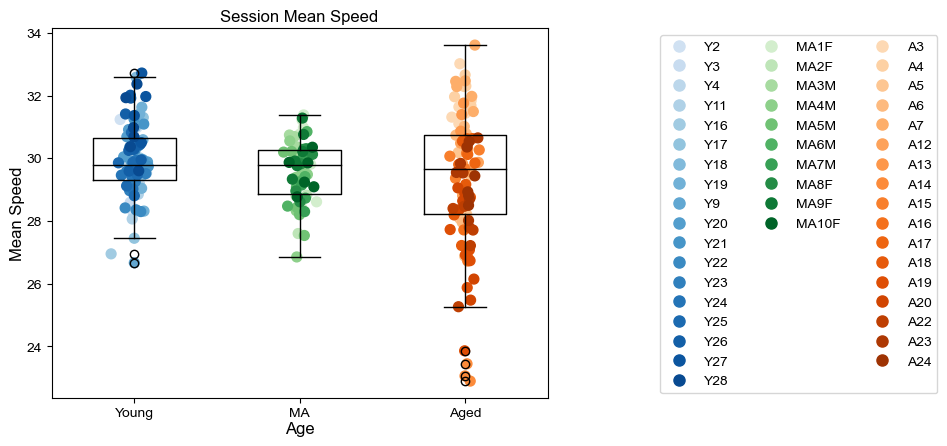

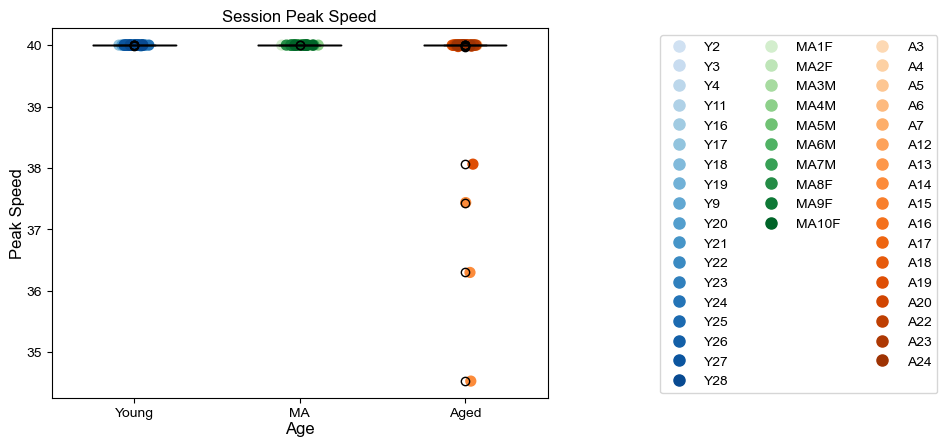

In [18]:
''' Compare Speed Distribution Features across Age Groups to Ensure Differences Collapse [Session Level] '''
fig, ax = plt.subplots()
meanspeed = [smeanspeed[y_sind], smeanspeed[ma_sind], smeanspeed[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(meanspeed, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(meanspeed)):
    y = meanspeed[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], s = 50)
            
ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('Session Mean Speed', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=12, labelpad=1)
ax.set_ylabel('Mean Speed', fontsize=12, labelpad=1)
plt.show()

fig, ax = plt.subplots()
peakspeed = [speakspeed[y_sind], speakspeed[ma_sind], speakspeed[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(peakspeed, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(peakspeed)):
    y = peakspeed[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], s = 50)
            
ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('Session Peak Speed', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=12, labelpad=1)
ax.set_ylabel('Peak Speed', fontsize=12, labelpad=1)
plt.show()

In [19]:
'''Compare Speed Metrics Statistically at the Session & Animal Level'''

print('meanspeedyoung ± SEM; meanspeed_MA ± SEM; meanspeed_old ± SEM')
print(str(np.round(np.mean(smeanspeed[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(smeanspeed[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(smeanspeed[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(smeanspeed[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(smeanspeed[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(smeanspeed[age_sind]), 2)))

stat, p_diff = stats.kruskal(smeanspeed[y_sind],smeanspeed[ma_sind],smeanspeed[age_sind])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('nmeanspeedyoung ± SEM; meanspeed_MA ± SEM; meanspeed_old ± SEM')
print(str(np.round(np.mean(mmeanspeed[y_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mmeanspeed[y_ind]), 2)) + ' ; ' 
      + str(np.round(np.mean(mmeanspeed[ma_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mmeanspeed[ma_ind]), 2)) + ' ; ' 
      + str(np.round(np.mean(mmeanspeed[age_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mmeanspeed[age_ind]), 2)))

stat, p_diff = stats.kruskal(mmeanspeed[y_ind],mmeanspeed[ma_ind],mmeanspeed[age_ind])
print('stat = ' + str(stat))
print('p_animal = ' + str(p_diff))

print('\npeakspeedyoung ± SEM; peakspeed_MA ± SEM; peakspeed_old ± SEM')
print(str(np.round(np.mean(speakspeed[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speakspeed[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speakspeed[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speakspeed[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speakspeed[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speakspeed[age_sind]), 2)))

stat, p_diff = stats.kruskal(speakspeed[y_sind],speakspeed[ma_sind],speakspeed[age_sind])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

print('\npeakspeedyoung ± SEM; peakspeed_MA ± SEM; peakspeed_old ± SEM')
print(str(np.round(np.mean(mpeakspeed[y_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mpeakspeed[y_ind]), 2)) + ' ; ' 
      + str(np.round(np.mean(mpeakspeed[ma_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mpeakspeed[ma_ind]), 2)) + ' ; ' 
      + str(np.round(np.mean(mpeakspeed[age_ind]), 2)) + ' ± ' + str(np.round(stats.sem(mpeakspeed[age_ind]), 2)))

stat, p_diff = stats.kruskal(mpeakspeed[y_ind],mpeakspeed[ma_ind],mpeakspeed[age_ind])
print('stat = ' + str(stat))
print('p_animal = ' + str(p_diff))

meanspeedyoung ± SEM; meanspeed_MA ± SEM; meanspeed_old ± SEM
29.93 ± 0.12 ; 29.6 ± 0.13 ; 29.39 ± 0.22
stat = 2.8502142082151067
p_session = 0.24048270514345302
nmeanspeedyoung ± SEM; meanspeed_MA ± SEM; meanspeed_old ± SEM
29.77 ± 0.16 ; 29.46 ± 0.19 ; 29.16 ± 0.54
stat = 1.4583385431467093
p_animal = 0.48230949191842065

peakspeedyoung ± SEM; peakspeed_MA ± SEM; peakspeed_old ± SEM
40.0 ± 0.0 ; 40.0 ± 0.0 ; 39.86 ± 0.07
stat = 3.0500686876486043
p_session = 0.21761358305423184

peakspeedyoung ± SEM; peakspeed_MA ± SEM; peakspeed_old ± SEM
40.0 ± 0.0 ; 40.0 ± 0.0 ; 39.85 ± 0.15
stat = 0.5184351615042146
p_animal = 0.7716551074781159


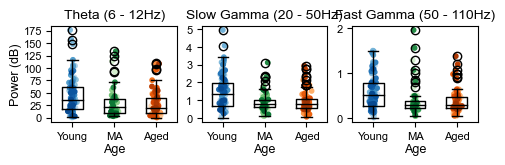

In [20]:
''' Plot Session Power Results (Figure 4c)'''
labels = ['Young','MA','Aged']
w = 0.5

fig, ax = plt.subplots(1, 3, figsize=(5.5, 1.25), sharey = False)
stp_tog = [stp[y_sind],stp[ma_sind],stp[age_sind]]
ax[0].boxplot(stp_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[0].set_title('Theta (6 - 12Hz)', fontsize=10, pad=5)
ax[0].set_xlabel('Age', fontsize=9, labelpad=1)
ax[0].set_ylabel('Power (dB)', fontsize=9, labelpad=1)
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,25,50,75,100,125,150,175])
ax[0].set_ylim(auto=True)

for i in range(len(stp_tog)):
    y = stp_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[0].scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

sSG_tog = [sSGp[y_sind],sSGp[ma_sind],sSGp[age_sind]]
ax[1].boxplot(sSG_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[1].set_title('Slow Gamma (20 - 50Hz)', fontsize=10, pad=5)
ax[1].set_xlabel('Age', fontsize=9, labelpad=1)
ax[1].set_ylim(auto=True)
ax[1].set_yticks([0,1,2,3,4,5])
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Power', fontsize=9, labelpad=1)

for i in range(len(sSG_tog)):
    y = sSG_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[1].scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)      

sFG_tog = [sFGp[y_sind],sFGp[ma_sind],sFGp[age_sind]]
ax[2].boxplot(sFG_tog, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax[2].set_title('Fast Gamma (50 - 110Hz)', fontsize=10, pad=5)
ax[2].set_xlabel('Age', fontsize=9, labelpad=1)
ax[2].set_ylim(auto=True)
ax[2].tick_params(labelsize = 8)
#ax[2].set_ylabel('Power', fontsize=9, labelpad=1)

for i in range(len(sFG_tog)):
    y = sFG_tog[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    ax[2].scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)      
    
#ax[2].legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right', bbox_to_anchor=(1.90, 1.1))
plt.savefig(save_folder + '4C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '4C.svg', dpi=400, bbox_inches='tight')
plt.show()

In [21]:
'''Kruskal Wallis Test of Session Power across by Age Group'''
print('tpyoung ± SEM; tp_MA ± SEM; tp_old ± SEM')
print(str(np.round(np.mean(stp[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(stp[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(stp[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(stp[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(stp[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(stp[age_sind]), 4)))

stat, p_diff = stats.kruskal(stp[y_sind],stp[ma_sind],stp[age_sind])
print('stat = ' + str(stat))
print('p_tpsession = ' + str(p_diff))

print('\nSGpyoung ± SEM; SGpMA ± SEM; SGpold ± SEM')
print(str(np.round(np.mean(sSGp[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sSGp[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sSGp[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sSGp[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sSGp[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sSGp[age_sind]), 4)))

stat, p_diff = stats.kruskal(sSGp[y_sind],sSGp[ma_sind],sSGp[age_sind])
print('stat = ' + str(stat))
print('p_SGpsession = ' + str(p_diff))


print('\nFGpyoung ± SEM; FGpMA ± SEM; FGpold ± SEM')
print(str(np.round(np.mean(sFGp[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sFGp[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFGp[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sFGp[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFGp[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sFGp[age_sind]), 4)))

stat, p_diff = stats.kruskal(sFGp[y_sind],sFGp[ma_sind],sFGp[age_sind])
print('stat = ' + str(stat))
print('p_FGpsession = ' + str(p_diff))

tpyoung ± SEM; tp_MA ± SEM; tp_old ± SEM
43.6629 ± 3.5621 ; 30.4137 ± 3.9441 ; 27.2906 ± 2.3994
stat = 14.286850241012985
p_tpsession = 0.0007900414697658098

SGpyoung ± SEM; SGpMA ± SEM; SGpold ± SEM
1.4596 ± 0.0941 ; 0.9371 ± 0.0774 ; 0.9236 ± 0.0577
stat = 21.629127110248874
p_SGpsession = 2.010456699303647e-05

FGpyoung ± SEM; FGpMA ± SEM; FGpold ± SEM
0.5715 ± 0.0372 ; 0.3887 ± 0.047 ; 0.3523 ± 0.0249
stat = 23.43930780063579
p_FGpsession = 8.132404673679006e-06


In [22]:
''' LFP Theta Power Post-Hoc Test '''
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

hue_order = [1.0, 3.0, 2.0]

sexes = []
seshmice = []
seshcount = []
seshage = []
seshtask = []
seshcohort = []

for m, session in zip(mice, sessions):
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    mtask = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Task'])
    mcohort = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    meansesh = len(session)
    
    for i, s in enumerate(session):
        sexes = np.append(sexes, msex)
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)
        seshtask = np.append(seshtask, mtask)
        seshcohort = np.append(seshcohort, mcohort)
        
# Collect all relevant data into pandas dataframe
Animal_ID = list(seshmice)
Session = list(seshcount)
Sex = list(sexes)
Age_Group = list(seshage)
Cohort = list(seshcohort)
Task = list(seshtask)
tp = list(stp)
SGp = list(sSGp)
FGp = list(sFGp)

tuples = list(zip(Animal_ID, Session, Sex, Age_Group, Task, Cohort, tp, SGp, FGp))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'Sex', 'AgeGroup','Task', 'Cohort','tp','SGp','FGp'])

import statsmodels.api as sm
import scikit_posthocs as ph

#Multiple comparisons non-parametric conover SGp
ph.posthoc_conover(df, val_col = 'tp', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.008611,0.001238
2.0,0.008611,1.000000,0.831132
3.0,0.001238,0.831132,1.000000


In [23]:
''' LFP Slow Gamma Power Post-Hoc Test '''
ph.posthoc_conover(df, val_col = 'SGp', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.000441,0.000052
2.0,0.000441,1.000000,0.968464
3.0,0.000052,0.968464,1.000000


In [24]:
''' LFP Fast Gamma Post-Hoc Test '''
ph.posthoc_conover(df, val_col = 'FGp', group_col = 'AgeGroup', p_adjust = 'holm')

,1.0,2.0,3.0
1.0,1.000000,0.000244,0.000021
2.0,0.000244,1.000000,0.948678
3.0,0.000021,0.948678,1.000000
